# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

## modelling of Launch Segment

> Apollo 11 https://www.hq.nasa.gov/alsj/nasa58040.pdf
<br>
> Apollo 17 https://history.nasa.gov/alsj/a17/A17_MissionReport.pdf

In [4]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt


In [46]:
# set launch carrier properties
# EL3 - European Large Logistics Lander
mass_dry  = 1600 # kg
mass_full = 8500 # kg
mass_fuel = mass_full - mass_dry # kg
m_flow = 10 # [kg/s] massflow
I_sp = 453 # [s] specific impulse
g_0 = 9.80665 # [kg/s²] standard gravity
EEV = I_sp * g_0 # [m/s] effective exhaust velocity


r_moon = 1737400    # [m] volumetric mean radius of the moon
m_moon = 0.07346e24 # [kg] mass of the moon
G = 6.67430e-11 # Gravitational constant



# acceleration direction from propulsion
#         0°
#         │                
# 270° ───┼─── 90°     reference angle from vertical axis, perpendicular to lunar surface
#         │
#        180°

def vec_from_angle(deg): # in [x,y] cartesian-coordinates
    rad = np.deg2rad(90-deg)

    y = np.sin(rad)
    x = np.cos(rad)
    vec = np.array([x,y,0], dtype=np.float64)
    
    
    # verify
    vector_1 = [1, 0, 0]
    vector_2 = vec

    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    print(f'vector angle is {np.rad2deg(angle)}°')
    
    return vec

def plot_vector(vec):
    
    plt.figure(figsize=(3, 3), dpi=50)
    
    # reference vector
    xpoints = np.array([0, 0])
    ypoints = np.array([0, 1])
    plt.plot(xpoints, ypoints, '--', color = 'b')
    
    xpoints = np.array([0, vec[0]])
    ypoints = np.array([0, vec[1]])
    plt.plot(xpoints, ypoints, color = 'r')
    
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    #unit circle
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), linewidth=2)
    
    plt.axis('off')
    plt.show()

In [155]:
def norm(vec):
    # r = length of pos vector
    return np.linalg.norm(vec)

def conv_vec_to_r_sys(vec, pos):
    # input vec  = [x,y,z]
    # 2D: input  = [x,y]
    
    #e_r = pos / norm(pos)                                   # e_r     in [x,y,z] coordinates
    #e_phi = np.array([-e_r[1],e_r[0],0], dtype=np.float64)  
    #e_phi = e_phi / norm(e_phi)                             # e_phi   in [x,y,z] coordinates
    #e_theta = np.array([0,0,1], dtype=np.float64)           # e_theta = e_z
    
    #e_x = np.array([np.cos(alpha), np.sin(alpha), 0], dtype=np.float64) # e_x in [e_r, e_phi, e_theta]
    #e_y = np.array([np.sin(alpha), np.cos(alpha), 0], dtype=np.float64) # e_y in [e_r, e_phi, e_theta]
    #e_z = np.array([0,0,1]                          , dtype=np.float64) # e_z in [e_r, e_phi, e_theta]
    
    alpha = np.arctan(pos[0]/pos[1]) # angle [rad] of coordinate rotation = arcsin(y)
    
    x_val = vec[0]
    y_val = vec[1]
    z_val = vec[2]
    
    r_val     = x_val * np.cos(alpha) + y_val * np.sin(alpha)
    phi_val   = x_val * np.sin(alpha) + y_val * np.cos(alpha)
    theta_val = z_val
    
    return np.array([r_val, phi_val, theta_val], dtype=np.float64)
    # 2D output  = [e_r, e_phi]
    # output vec = [a, b, c] * [e_r, e_phi, e_theta]
    
def altitude(pos):
    r = norm(pos)
    return r - r_moon

def acc_grav_moon(pos):
    r = norm(pos)
    r_val = G * (m_moon/(r**2))
    e_r = -(pos / norm(pos))
    
    return (e_r * r_val)

def acc_centrifugal(pos,vel):
    r = norm(pos)
    v = conv_vec_to_r_sys(vel,pos)[1] # vel portion that is ⊥ to r -> phi_val
    r_val = (v**2)/(r)
    e_r = (pos / norm(pos))
    
    return (e_r * r_val)

print('test acc_grav_moon(r) function:',acc_grav_moon(np.array([0,r_moon,0])),'[m/s²]','vs. 1.622 [m/s²] expected on surface')

def acc_propulsion(m):
    F_thrust = m_flow * EEV
    return F_thrust / m
    
print('test acc_propulsion(m) function:',acc_propulsion(mass_full),'[m/s²]')


test acc_grav_moon(r) function: [-0.         -1.62426548 -0.        ] [m/s²] vs. 1.622 [m/s²] expected on surface
test acc_propulsion(m) function: 5.226367588235294 [m/s²]


### Velocity Verlet algorithm


┌───────────┬─────────────────────────────────┐
│  Phase 1  │          Vertical rise          │
└───────────┴─────────────────────────────────┘
vector angle is 90.0°


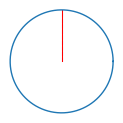


┌───────────┬─────────────────────────────────┐
│  Phase 2  │      first tilt, 38° burn       │
└───────────┴─────────────────────────────────┘
vector angle is 52.0°


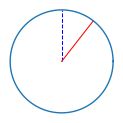


┌───────────┬─────────────────────────────────┐
│  Phase 3  │     second tilt, 52° burn       │
└───────────┴─────────────────────────────────┘
vector angle is 38.00000000000001°


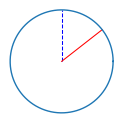


┌───────────┬─────────────────────────────────┐
│  Phase 4  │   orbit injection, 89.66° burn  │
└───────────┴─────────────────────────────────┘
vector angle is 10.339999999999979°


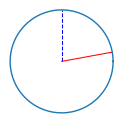


┌───────────┬─────────────────────────────────┐
│  Phase 5  │   orbit propagate, engine off   │
└───────────┴─────────────────────────────────┘


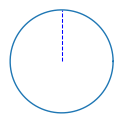


├───────────────── FINISHED ──────────────────┤



In [263]:
# SIMULATION
    
# setup parameters
t_step = 0.1 # [s] time for one simulation step
t_step = np.array(t_step, dtype=np.float64) 
digit_precision = 3

time = np.array(0, dtype=np.float64)

# cartesian coordinates - 3D
#         y   z
#         │ /              
#      ───┼─── x    [x,y,z]
#       / Moon       
# point of origin = moon center mass point

# Spacecraft properties
# mass
m = mass_full  # [kg]

# position
pos = np.array([0,r_moon,0], dtype=np.float64) # [m]

# velocity
#add ground speed vel
vel = np.array([0,0,0], dtype=np.float64) # [m/s]

# acceleration
acc = np.array([0,0,0], dtype=np.float64) # [m/s²]

# engine toggle
engine_on = True


# pandas df for logging
df = pd.DataFrame(columns=['time [s]','mass [kg]', 'altitude [m]','pos_x [m]','pos_y [m]','pos_z [m]', 'vel_x [m/s]','vel_y [m/s]', 'vel_z [m/s]','acc_x [m/s²]','acc_y [m/s²]','acc_z [m/s²]'])
df.loc[0] = [time, m, altitude(pos), pos[0], pos[1], pos[2], vel[0], vel[1], vel[2], acc[0], acc[1], acc[2]]

def log(x=1,full=False):
    if full:
        # full logging - WARNING : slow!
        df.loc[df.shape[0]] = [time, m, altitude(pos), pos[0], pos[1], pos[2], vel[0], vel[1], vel[2], acc[0], acc[1], acc[2]]
    else:
        # logging results only every x seconds
        if (time*1000)%(x) == 0:
            df.loc[df.shape[0]] = [time, m, altitude(pos), pos[0], pos[1], pos[2], vel[0], vel[1], vel[2], acc[0], acc[1], acc[2]]
            
def phys_sim_step():
    
    global time, pos, vel, acc, m
    
    # one sim step BEGIN
    ###############################
    new_pos = pos + ( vel * t_step)
    new_vel = vel + ( acc * t_step)
    new_acc = (dir_n * acc_propulsion(m)) + acc_grav_moon(pos) #+ acc_centrifugal(pos,vel)
    
    if engine_on: new_mass = m - (m_flow * t_step)
    else: new_mass = m
    
    pos = new_pos
    vel = new_vel
    acc = new_acc
    m = new_mass
    
    time = np.around(time + t_step,digit_precision)

    ###############################
    # one sim step END
    

# Simulation execution



print('''
┌───────────┬─────────────────────────────────┐
│  Phase 1  │          Vertical rise          │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(0)
plot_vector(dir_n)

# stop condition: vertical velocity
# 50 [ft/s] = 15.25 [m/s]
#while vel[1] < 15.25: 
while time < 10: 
    
    phys_sim_step()
    
    log(1000) # log every x [ms]
        

print('''
┌───────────┬─────────────────────────────────┐
│  Phase 2  │      first tilt, 38° burn       │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(38)
plot_vector(dir_n)

# stop condition: vertical velocity
# 70 [ft/s] = 21.34 [m/s]
#while vel[1] < 21.34:
while time < 12: 
    
    phys_sim_step()
    
    log(1000) # log every x [ms]


print('''
┌───────────┬─────────────────────────────────┐
│  Phase 3  │     second tilt, 52° burn       │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(52)
plot_vector(dir_n)

# stop condition: vertical velocity
# 73 [ft/s] = 22.25 [m/s]
#while vel[1] < 22.25:
while time < 16: 
    
    phys_sim_step()
    
    log(1000) # log every x [ms]

# Phase 4: Orbit injection
print('''
┌───────────┬─────────────────────────────────┐
│  Phase 4  │   orbit injection, 89.66° burn  │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(79.66)
plot_vector(dir_n)

while vel[0] < 1800:
    
    phys_sim_step()
    
    log(1000) # log every x [ms]

print('''
┌───────────┬─────────────────────────────────┐
│  Phase 5  │   orbit propagate, engine off   │
└───────────┴─────────────────────────────────┘''')

dir_n =  np.array([0,0,0], dtype=np.float64)
plot_vector(dir_n)
engine_on = False

now_time = time
while time < now_time + 20000:
    
    phys_sim_step()
    
    log(1000) # log every x [ms]

    
print('''
├───────────────── FINISHED ──────────────────┤
''')
#print(df)



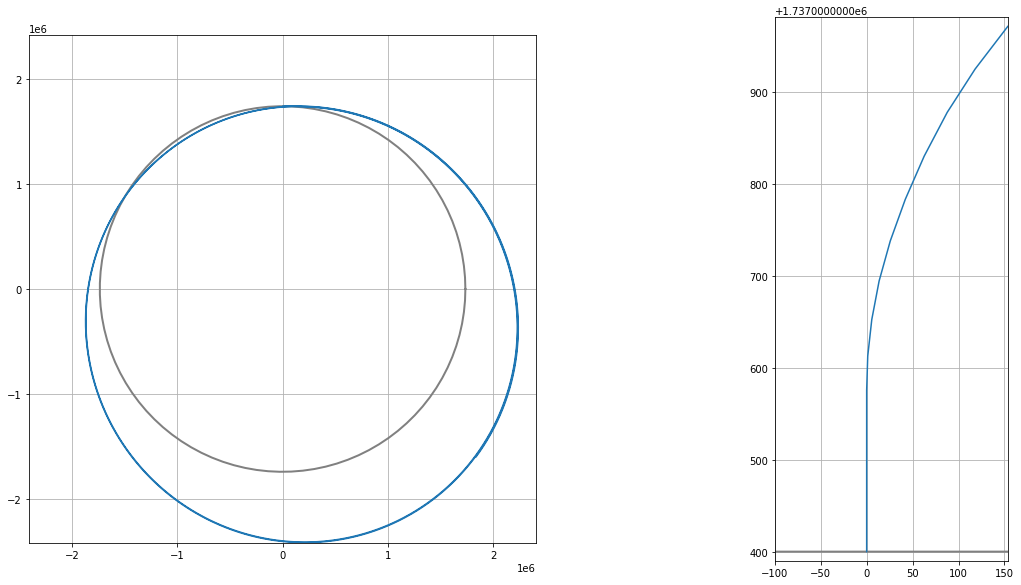

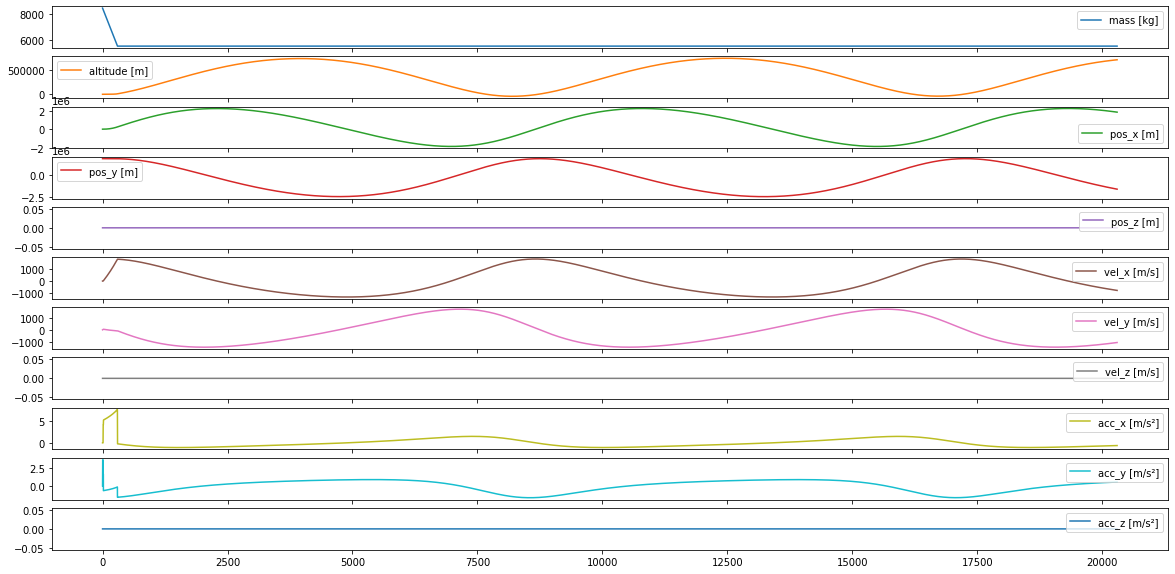

In [264]:
# plot path cartesian
dpi = 72

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10),dpi=dpi)


xpoints = df['pos_x [m]'].values
ypoints = df['pos_y [m]'].values

# left

# moon surface
t = np.linspace(0,2*np.pi,100)
ax1.plot(r_moon*np.cos(t), r_moon*np.sin(t),color='grey', linewidth=2)

ext = np.max(np.abs([xpoints,ypoints]))

ax1.set_ylim(-ext, ext)
ax1.set_xlim(-ext, ext)
ax1.set_aspect('equal', adjustable='box')
ax1.grid(True)
ax1.plot(xpoints,ypoints)

# right
# moon surface
t = np.linspace(0.49*np.pi,0.51*np.pi,1000)
ax2.plot(r_moon*np.cos(t), r_moon*np.sin(t),color='grey', linewidth=2)

slice_n = 20
max_x = np.max(xpoints[:slice_n])
max_y = np.max(ypoints[:slice_n])
min_x = np.min(xpoints[:slice_n])
min_y = np.min(ypoints[:slice_n])

pad_y = 1e1
pad_x = 1e2

ax2.set_xlim(min_x-pad_x, max_x)
ax2.set_ylim(min_y-pad_y, max_y+pad_y)

ax2.set_aspect('equal', adjustable='box')
ax2.grid(True)
ax2.plot(xpoints[:slice_n],ypoints[:slice_n])

#plt.axis('off')
plt.show()




# plot result properties graphs
df.plot(subplots=True,figsize=(20,10))
plt.show()

In [17]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [18]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [3]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [21]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

agi.stk12.stkobjects.AgStkObjectRoot

In [5]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [7]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [8]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [10]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [15]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [16]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

Result image resolution: 73.0 x 37.0
number of calculations: 2701.0

73 [-180, -175, -170, -165, -160, -155, -150, -145, -140, -135, -130, -125, -120, -115, -110, -105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]

37 [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60, -65, -70, -75, -80, -85, -90]


  0%|          | 0/2701.0 [00:00<?, ?it/s]

STKRuntimeError: Position central bodies were not equivalent.

### save result in xArray

In [7]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

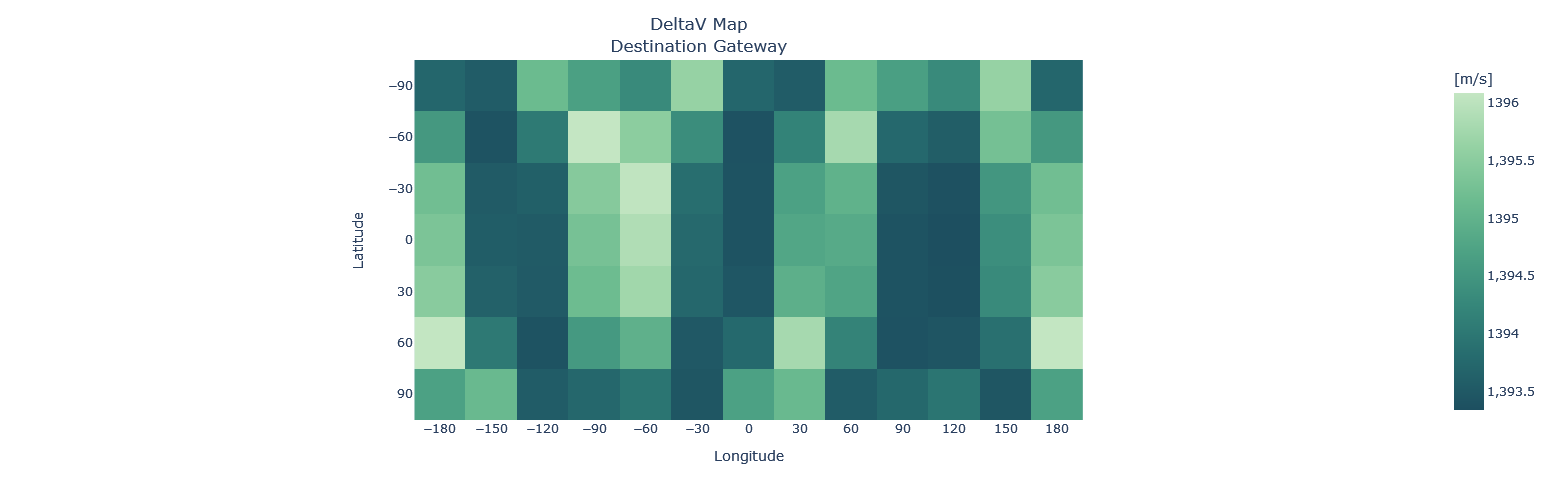

In [14]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK